# Задача классификации 

In [1]:
import torch
import random
import numpy as np

# параметры, что бы мы могли воспроизвести эксперимент
# зафиксируем случайность 
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Функция SoftMax может выдать одинаковые вероятности для разных классов

Сумма выходов функции SoftMax равна 1 (с точностью до машинного нуля)

In [17]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x
    
    # считаем вероятности 
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x) # считается долго
        return x
    
wine_net = WineNet(5)

In [18]:
# использует выходы из нейросети непропущенные через softmax
loss = torch.nn.CrossEntropyLoss()

# считаем градиетные шаги
optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

# Вопрос 
Наша нейросеть – это сложная функция от входов, параметризованная весами и смещениями (bias). Давайте разберемся, как выглядит ее аналитический вид:

Возьмем первый полносвязный слой (torch.nn.Linear). Он принимает на вход вектор одного объекта x⃗\vec{x}x

из k чисел. В нашем случае у объекта 2 признака, значит k=2. Сам слой содержит n_hidden_neurons. У каждого нейрона этого слоя k весов (по одному весу на вход) и по одному значению bias. Каждый нейрон отдает 1 число: таким образом, выход слоя – это вектор из n чисел.

Функцию полносвязного слоя можно представить в виде матричного перемножения x⃗\vec{x}x
и матрицы весов всех нейронов слоя, где один нейрон отвечает одному столбцу в матрице:

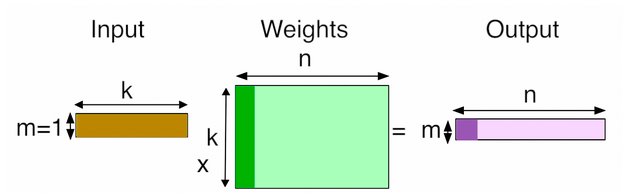

При этом нужно не забыть про bias. Один из способов его учесть: расширить x⃗\vec{x}x

, добавив к нему 1 в качестве последнего значения. В таком случае, bias будет просто одним из весов, который всегда умножается на 1. На картинке выше значения bias'ов будут находится в последней строчке матрицы весов.

Получается, формула для вычисления выходов из первого слоя выглядит следующим образом:

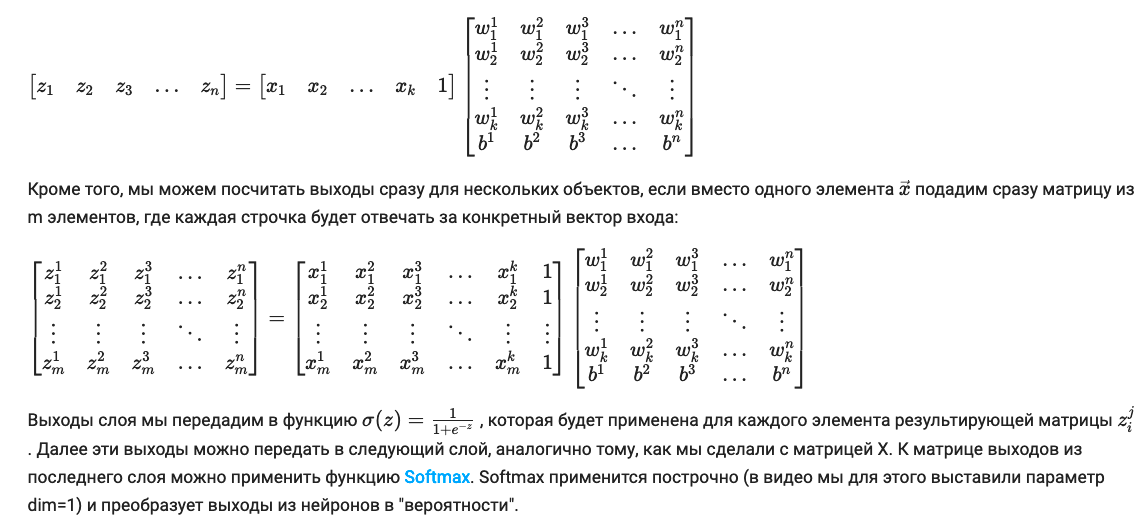

[Softmax](https://ru.wikipedia.org/wiki/Softmax)

# Ответ
Берём активированные результаты предыдущего слоя Sigmoid(X*W1+b1) как входные данные (Х) для следующего и т.д. Также не забываем, что использовать сигмоид в последнем слое не нужно, т.к. его активированные результаты уже будут выходом из сети, а этим, в данном случае, занимается Softmax

Softmax(Sigmoid(Sigmoid(X*W1+b1)*W2+b2)*W3+b3)

In [19]:
# мы делаем разбивку потому что датасет может быть большим, и прогонка по эпоху может занять много времени

np.random.permutation(5)

array([1, 3, 0, 4, 2])

In [20]:
batch_size = 10

for epoch in range(5000):
    order = np.random.permutation(len(X_train)) # в каждой эпохе будем делать перемешивание 
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]  # делаем подмножества 
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    
    # из каждой 100 эпох будем брать метрики
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1) # какой выход наибольший
        print((test_preds == y_test).float().mean()) # сравнить номер класса нейрона с номером в тестовой выборке
        
    # Каждые 100 эпох мы будем вычислять метрики на тестовом датасете чтобы посмотреть, обучается у нас нейросеть, или нет.
    # То есть каждые 100 эпох мы делаем forward по тестовым данным, получаем тестовые prediction, и вычисляем, 
    # какой выход был максимальный. То есть опять же чтобы понять, какой класс предсказывает нейросеть,
    # не обязательно вычислять софтмакс, не обязательно вычислять вероятности. Нам достаточно посмотреть: 
    # а какой выход был наибольший, и он же и будет впоследствии выходом с максимальной вероятностью. 
    # То есть нам нужно посчитать argmax у выходов нейронной сети, это будет номер нейрона, и сравнить его с тем номером класса,
    # который находится в Y_test. После этого мы хотим посчитать: а какая доля вот этого совпадения, 
    # когда у нас нейрон с максимальным выходом совпал с реально правильным классом. 
    # Нам нужно посчитать среднее значение, но среднее значение мы не можем посчитать у целочисленного тензора, 
    # который получается в результате этого сравнения, поэтому мы сначала его превратим к дробному тензору и
    # вызовем у него метод mean(), и будем его распечатывать.    

tensor(0.3519)
tensor(0.3889)
tensor(0.5000)
tensor(0.5000)
tensor(0.5185)
tensor(0.5370)
tensor(0.5370)
tensor(0.5370)
tensor(0.7593)
tensor(0.7778)
tensor(0.8519)
tensor(0.8519)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.9074)
tensor(0.8889)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8889)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.9074)
tensor(0.8889)
tensor(0.8889)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.9074)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)


# Вопрос

В нашем примере мы делим датасет на батчи (batch).
Одна эпоха, то есть итерация просмотра всего датасета, у нас бьётся на много маленьких частей -  батчей (batch).
Батч содержит данные из обучающей выборки.

Отметьте правильные утверждения:

# Ответ 


Одна из причин использовать батчи – экономия оперативной и видео-памяти

В нашем случае гарантируется, что при обучении нейронная сеть увидит весь обучающий датасет за одну эпоху

Полезно перед каждой эпохой перемешивать порядок объектов

[эпоха, батч, итерация](https://neurohive.io/ru/osnovy-data-science/jepoha-razmer-batcha-iteracija/)

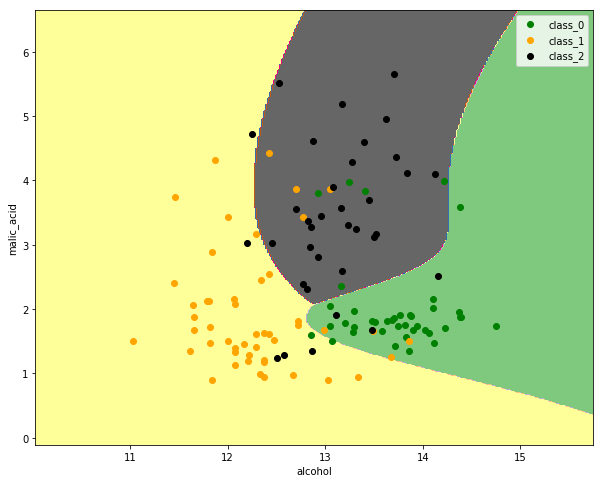

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

# Задание 1

Фиксирование seed не гарантирует, что код будет одинаково выполняться на разных компьютерах. Но на одной и той же машине вы будете получать одинаковые результаты, перезапуская один и тот же скрипт.

Например, функция random.randint(start, end) отдает случайное целое число в диапазоне от start, end (включительно). Запуская скрипт, состоящий из вызова этой функции, вы будете получать разные ответы. 

В этом задании вам нужно подобрать seed, чтобы функция random.randint(0, 10) выдала число 5

PS: надо понимать, что фиксирование random seed не приведет к тому, что повторный вызов random.randint(0, 10) внутри того же скрипта снова даст 5. 

In [1]:
import random


for i in range(20):
    random.seed(i)
    print(i, random.randint(0, 10))

0 6
1 2
2 0
3 3
4 3
5 9
6 9
7 5
8 3
9 7
10 9
11 7
12 7
13 4
14 1
15 3
16 5
17 8
18 2
19 10
